In [1]:
import os
import sys
import platform
import torch
import torchaudio
TORCHAUDIO_USE_BACKEND_DISPATCHER=0
sys.path.append('/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/')

import scipy.io
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(threshold=4)
import torch

import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

import local_functions as f
import AK_ILD_pytorch as ak
import NN_optimizer as nn_opt




# Intro:
### In this notebook we load a .mat file with HRTF SH coefficients (and some other things) and optimize them to reduce the ILD error

| Variable           | dimensions                                                      | description |
| :----------------  | :------                                                         | :--- |
| p_f_high_lebedev   |  [$\Omega$ x positive frequencies x left/right]                 | Measured HRTF which represents the reference binaural signals from all directions |
| ILD_ref            |  [$f_c$ x $\Omega_{az}$ ]                                       | Reference ILD curve, based on the messured HRTF |
| f_band             |  [$f_{low}$ , $f_{high}$]                                       | The lower and upper frequency band for the ILD calculations |
| Hnm_low            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH least squeres coefficients |
| Hnm_mls            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH magnitude least squeres coefficients |
| Hnm_high           |  [$(N_{high}+1)^2$ x positive frequencies x  left/right ]       | The high order SH least squeres coefficients |
| fs                 |  scalar                                                         | sample rate |
| N_low              |  scalar                                                         | low order |
| N_high             |  scalar                                                         | high order for refference |
| f_vec              |  [$f$ x 1]                                                      | positive frequencies bins vector |
| ang_vec            |  [$\Omega_{az}$ x 1]                                            | Angles in degrees for ILD calculations |
| Y_high_lebedev     |  [$\Omega$ x $(N_{high}+1)^2$]                                  | SH matrix for high order over lebedev directions |
| Y_high_az          |  [$\Omega_{az}$ x $(N_{high}+1)^2$]                             | SH matrix for high order over azimuth directions |
| Y_low_lebedev      |  [$\Omega$ x $(N_{low}+1)^2$]                                   | SH matrix for low order over lebedev directions |
| Y_low_az           |  [$\Omega_{az}$ x $(N_{low}+1)^2$]                              | SH matrix for low order over azimuth directions |

Python Platform: macOS-13.4.1-arm64-i386-64bit
PyTorch Version: 2.2.2

Python 3.10.14 (main, Mar 21 2024, 11:21:31) [Clang 14.0.6 ]
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is cpu
p_f_high_lebedev torch.Size([2702, 257, 2]) 	 torch.complex128
ILD_ref 	 torch.Size([22, 361]) 		 torch.float64

Hnm_high	 torch.Size([1849, 257, 2]) 	 torch.complex128
Hnm_low		 torch.Size([4, 257, 2]) 	 torch.complex128
Hnm_mls		 torch.Size([4, 257, 2]) 	 torch.complex128

Y_high_lebedev	 torch.Size([2702, 1849]) 	 torch.complex128
Y_high_az	 torch.Size([361, 1849]) 	 torch.complex128
Y_low_lebedev	 torch.Size([2702, 4]) 		 torch.complex128
Y_low_az	 torch.Size([361, 4]) 		 torch.complex128

f_band		 (2,) 				 uint16
fs		 () 				 uint16
f_vec		 (257, 1) 			 float64
ang_vec		 (361, 1) 			 float64
N_high		 (1,) 				 uint8
N_low		 (1,) 				 uint8
Layer (type (var_name))                  Kernel Shape  Input Shape   Output Shape  Param #       Mult-Adds
NN_v2_simp (NN_v2_simp

Loading...:   0%|          | 0/200 [00:00<?, ?it/s]

Finished Training


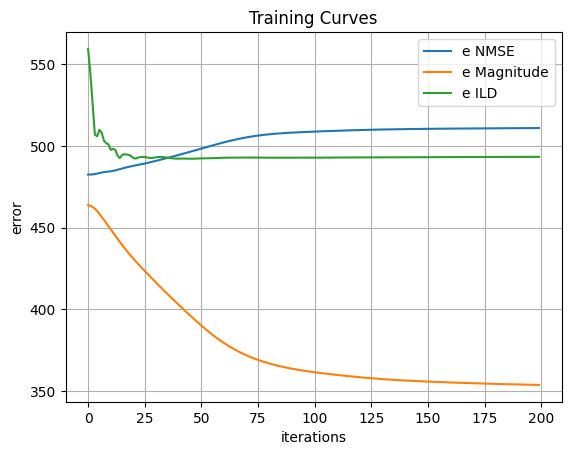

Time Frequcny plots for iMagLS
HRIR on lateral plane shape:  (361, 2, 512)
The channel-wise energy:  [0.1   1.456]


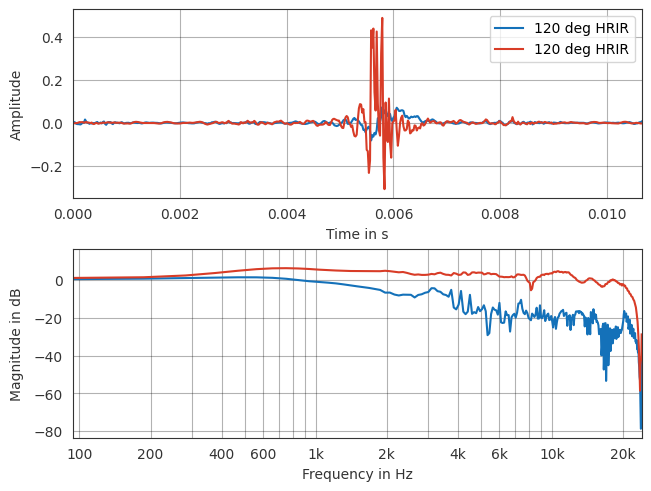

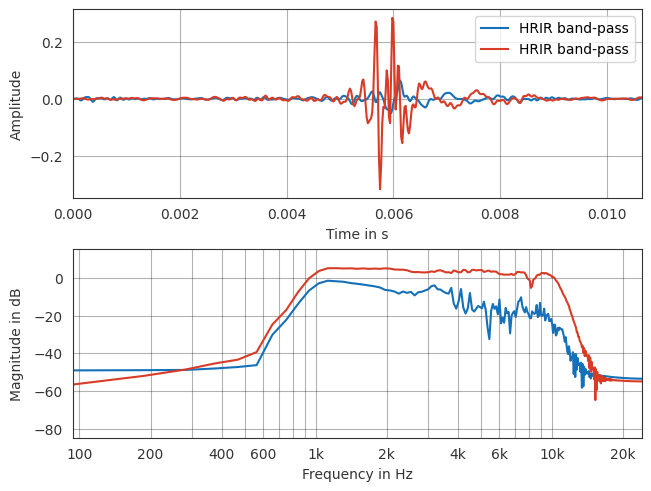

Time Frequcny plots for MagLS
HRIR on lateral plane shape:  (361, 2, 512)
The channel-wise energy:  [0.124 1.695]


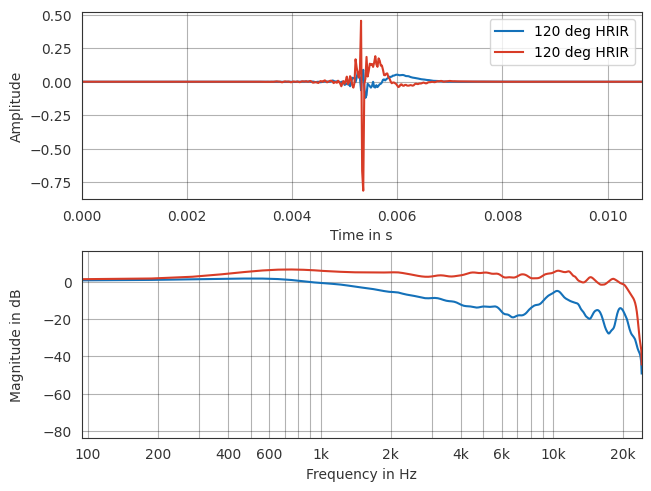

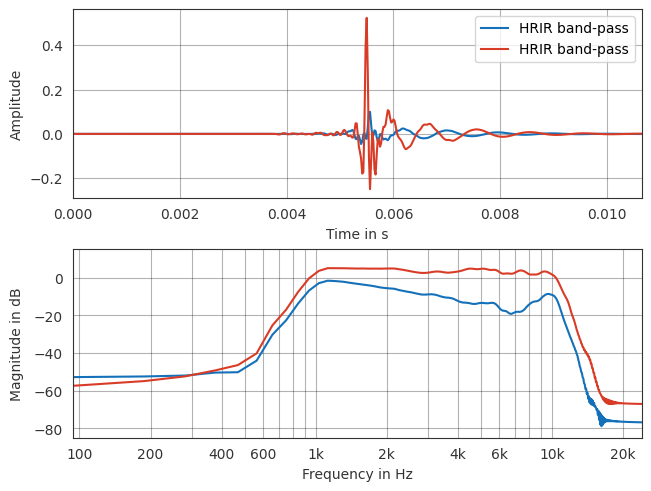

/Users/orberebi/anaconda3/envs/TUB-BGU-colab/lib/python3.10/site-packages/pyfar/io/io.py:465: UserWarning: wav-files of subtype PCM_16 are clipped to +/- 1.
  warnings.warn(


Time Frequcny plots for HOA
HRIR on lateral plane shape:  (361, 2, 512)
The channel-wise energy:  [0.101 2.049]


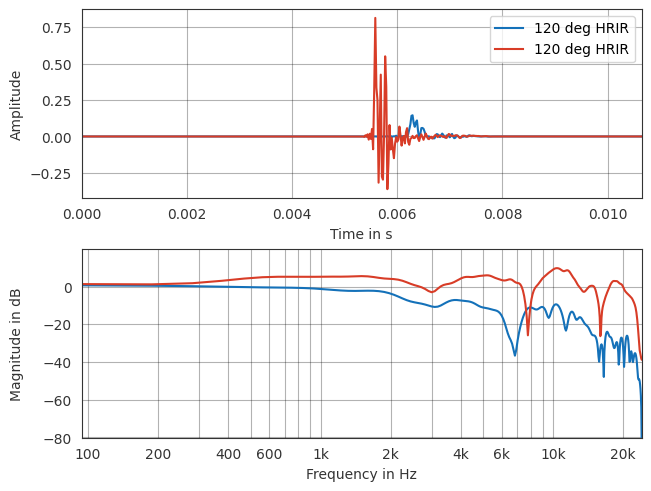

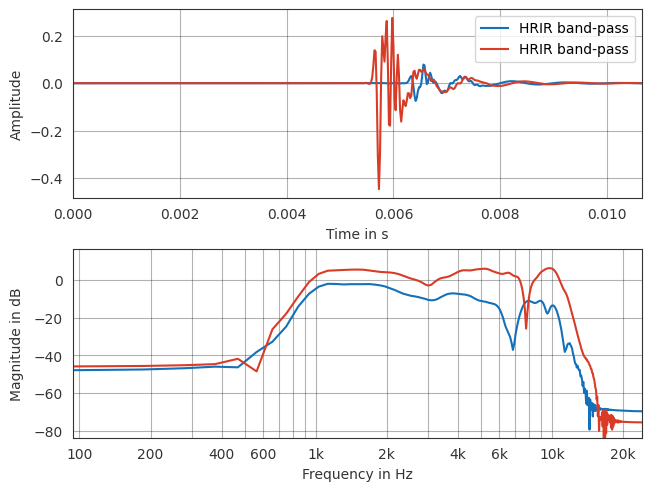

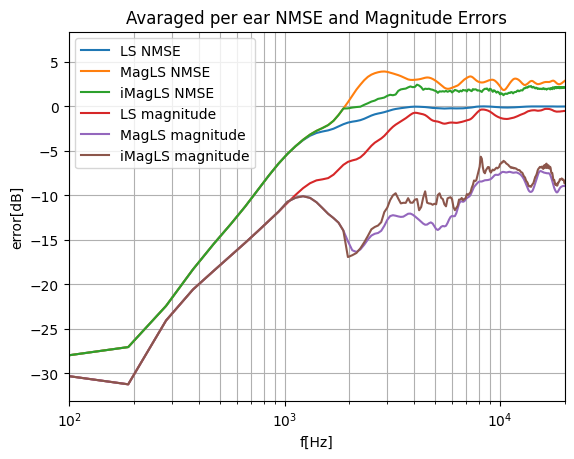

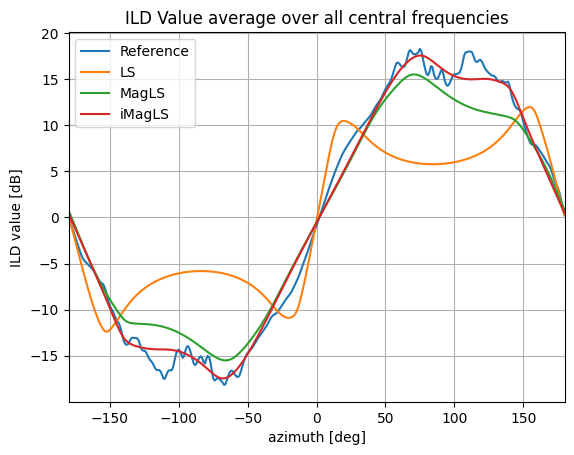

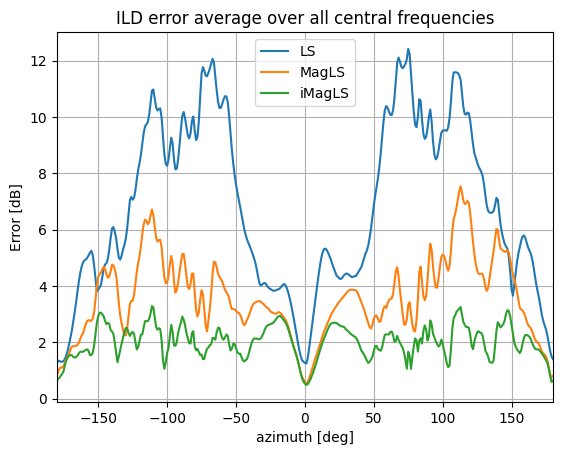

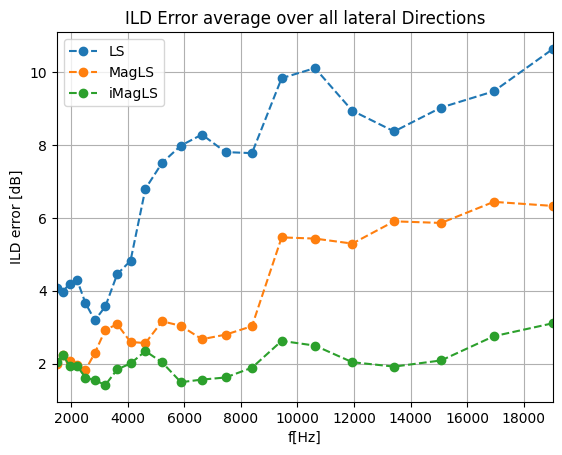

In [3]:
# The following block usees the path_matlab_data to load the data and calculate the iMagLS HRTF coeeftients
path_matlab_data = "/Users/orberebi/Documents/GitHub/TUB-BGU-colab/matlab_saved_data/08_04_24/KU100_HRIR_L2702_N1.mat"
lambda_vec=[2,1,1]
epochs = 200
nn_opt.start(path_matlab_data,epochs,lambda_vec,shutup=False,is_save=False)

